<a href="https://colab.research.google.com/github/AndyMDH/augmented_image_classification_sigmoid_relu/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCK506 Mid-Module Assignment: FashionMNIST Image Classification with Neural Networks
By: Andy Ho

**Table of Contents**
1. Introduction
2. Exploratory Data Analysis
3. Data Preprocessing
4. Building Model 1
  - Neural Network Architecture
  - Compiling
  - Training
  - Model Summary & Observations
5. Building Model 2
  - Neural Network Architecture
  - Compiling
  - Training
  - With Dropout Rates
  - Model Summary & Observations
6. Analysis and Retrospective



## Introduction
In this Jupyter Notebook, we explore the domain of Deep Learning (DL) through the implementation of a neural network tailored for the classification of images within the Fashion MNIST dataset. The goal of this summative assignment is to explore the efficacy of different configurations of neural network architectures and optimization techniques.

The Fashion MNIST dataset, comprising of 60,000 training images and 10,000 testing images, presents a rich resource for studying Machine Learning algorithms in the domain of apparel recognition. Each image in the dataset corresponds to one of ten distinct categories, representing various articles of clothing and accessories. The class in the MNIST dataset are as follows:

0.	T-shirt/top
1.	Trouser
2.	Pullover
3.	Dress
4.	Coat
5.	Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot

Our approach involves utilising a two hidden layer fully connected neural network, employing Stochastic Gradient Descent (SGD) as the optimiser, the Sigmoid Activation function, and the cross-entropy error function.

To begin, we'll set the parametres such as epoch=10 and batch size=1000 and proceed with training the neural network. Through this process, we aim to observe the performance metrics, including training loss, training accuracy, test loss, and test accuracy.

In the subsequent stage, we delve deeper into the intricacies of neural network optimization by introducing variations to our initial setup. Specifically, we replace the Sigmoid Activation function with Rectified Linear Units (ReLU) and incorporate Dropout regularization.

***Importing Dependencies***

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Loading Fashion MNIST Dataset**

To obtain the direct download link for the Fashion MNIST dataset, we can visit the Kaggle [dataset](https://www.kaggle.com/zalando-research/fashionmnist) and click on the **Download** button on the right-hand side of the page. Alternatively for the sake of this assignment, 'keras.datasets.fashion_mnist' provides a convenient manner for us to directly load the Fashion MNIST dataset into our Python environment.



In [3]:
# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


---
## Exploratory Data Analysis

In [4]:
# Check dataset dimensions
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [5]:
# Distribution of labels in training and test sets
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

print("Training set label distribution:")
for label, count in train_label_counts.items():
    print(f"Label {label}: {count} samples")

print("\nTest set label distribution:")
for label, count in test_label_counts.items():
    print(f"Label {label}: {count} samples")

Training set label distribution:
Label 9: 6000 samples
Label 0: 6000 samples
Label 3: 6000 samples
Label 2: 6000 samples
Label 7: 6000 samples
Label 5: 6000 samples
Label 1: 6000 samples
Label 6: 6000 samples
Label 4: 6000 samples
Label 8: 6000 samples

Test set label distribution:
Label 9: 1000 samples
Label 2: 1000 samples
Label 1: 1000 samples
Label 6: 1000 samples
Label 4: 1000 samples
Label 5: 1000 samples
Label 7: 1000 samples
Label 3: 1000 samples
Label 8: 1000 samples
Label 0: 1000 samples


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

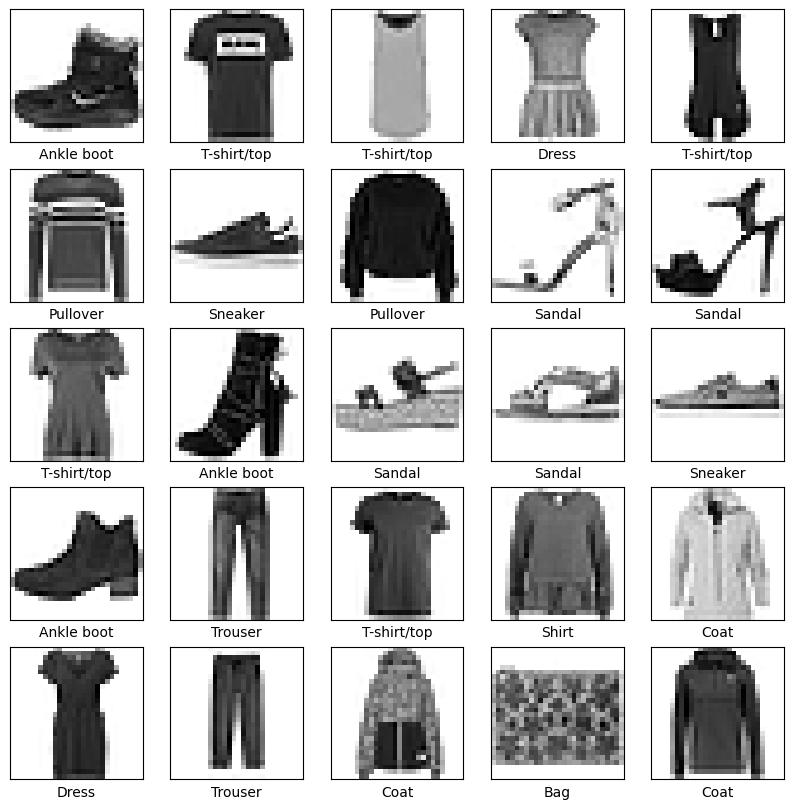

In [7]:
# Visualize sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

---
## Data Preprocessing
Before constructing our architecture, we need to preprocess our data. This stage involves adjusting the scale of our grayscale pixel values, originally ranging from 0 to 255, to a normalized scale between 0 and 1. We achieve this by dividing each pixel value in both the training and testing sets by 255.0. By scaling the pixel values to a smaller range, it simplifies the computational task for the model, aiding in its efficiency during training.

Additionally, we employ data augmentation techniques to enhance the robustness and generalisation capability of our model for image classification tasks. The **create_augmented_data_generator** function applies various transformations, such as rotation, shifts, and flipping, to augment the training dataset, thereby increasing its diversity and improving the model's ability to generalise to unseen data. The augmentation process is facilitated using the ImageDataGenerator class, while also ensuring that pixel values are rescaled to a normalized range.

The reshaped array transforms the original dataset into a 4-dimensional array, where each element represents an image. The dimensions are structured as follows:

- The first dimension denotes the number of images, automatically determined based on the size of the original array.
- The subsequent two dimensions represent the height and width of each image, set to 28x28 pixels in this case.
- Lastly, the fourth dimension signifies the number of channels per image, with a value of 1 indicating grayscale images. For color images, this value would typically be 3, representing the red, green, and blue channels.

In contrast, the **create_test_data_generator** function prepares the test dataset without augmentation, ensuring unbiased evaluation of the model's performance.

In [8]:
def create_augmented_data_generator(train_images, train_labels):
    # Call the ImageDataGenerator class for training data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255.  # Rescale training data
    )

    # Pass in arguments to the flow method for training data
    train_data_generator = train_datagen.flow(
        x=train_images.reshape(-1, 28, 28, 1),  # Reshape images to fit NN input shape
        y=train_labels,
        batch_size=32
    )

    return train_data_generator

def create_test_data_generator(test_images, test_labels):
    # Call the ImageDataGenerator class to rescale images for test data (without augmentation)
    test_datagen = ImageDataGenerator(rescale=1./255.)

    # Pass in arguments to the flow method for test data
    test_data_generator = test_datagen.flow(
        x=test_images.reshape(-1, 28, 28, 1),  # Reshape images to fit NN input shape
        y=test_labels,
        batch_size=32
    )

    return test_data_generator

In [9]:
# Call the function to create augmented data generator for training set
train_data_generator = create_augmented_data_generator(train_images, train_labels)

# Call the function to create data generator for test set
test_data_generator = create_test_data_generator(test_images, test_labels)

In [10]:
# Select one image from the training set
image = train_images[15].reshape(1, 28, 28, 1)

# Define the data augmentation generator
train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
)

# Generate augmented images from the single image
augmented_images = [train_datagen.flow(image, batch_size=1)[0][0] for _ in range(5)]

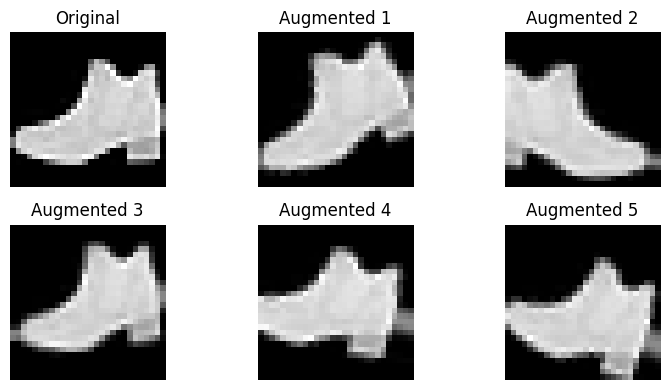

In [11]:
# Plot the original and augmented images
plt.figure(figsize=(8, 4))
plt.subplot(2, 3, 1)
plt.title('Original')
plt.imshow(image.reshape(28, 28), cmap='gray')
plt.axis('off')
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(2, 3, i + 2)
    plt.title(f'Augmented {i+1}')
    plt.imshow(augmented_image.reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Building Model 1
This stage involves constructing the model using a Keras Sequential model, comprising four distinct layers. This architecture embodies a feed-forward neural network architecture, propagating values from left to right, with each architectural layer described below.

In [12]:
# Defining our Neural Network architecture
model_1 = Sequential([
    Flatten(input_shape=(28, 28)),     # Input layer
    Dense(128, activation='sigmoid'),  # Input layer with 128 neurons
    Dense(64, activation='sigmoid'),   # First hidden layer with 64 neurons
    Dense(32, activation='sigmoid'),   # Second hidden layer with 32 neurons
    Dense(10, activation='softmax')    # Output layer with 10 neurons (for 10 classes) using softmax activation
])

# Compile the model
model_1.compile(optimizer=SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Layer 1:** Our input layer consists of 784 neurons, representing each pixel of the input image. We utilize the Flatten layer with an input shape of (28,28) to reshape the input into a vector of 784 neurons, ensuring each pixel corresponds to one neuron.

**Layer 2:** This is our first hidden layer, comprising 64 neurons. Employing the sigmoid activation function, each neuron in this layer is fully connected to neurons from the preceding layer, facilitating nonlinear transformations of the input data.

**Layer 3:** Serving as the second hidden layer, this dense layer encompasses 32 neurons. Similar to the previous hidden layer, it employs the sigmoid activation function and is fully connected to the neurons of the preceding layer, further enabling the network to extract complex features from the data.

**Layer 4:** Serving as the output layer, this dense layer consists of 10 neurons, corresponding to the 10 distinct classes in our classification task. Utilizing the softmax activation function, this layer computes a probability distribution across the classes, enabling the model to assign probabilities to each class. Neuron values within this layer range between 0 and 1, with higher values indicating higher probabilities of the associated image belonging to the respective class.

In [13]:
# Train the model
history = model_1.fit(train_data_generator,
                    epochs=10,
                    batch_size=1000,
                    validation_data=test_data_generator)

Epoch 1/10
1875/1875 [==============================] - 27s 14ms/step - loss: 1.7065 - accuracy: 0.3404 - val_loss: 1.2271 - val_accuracy: 0.4971
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 1.1637 - accuracy: 0.5560 - val_loss: 0.9570 - val_accuracy: 0.6516
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.9618 - accuracy: 0.6422 - val_loss: 0.8129 - val_accuracy: 0.6914
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.8607 - accuracy: 0.6731 - val_loss: 0.7502 - val_accuracy: 0.7072
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.8042 - accuracy: 0.6888 - val_loss: 0.7048 - val_accuracy: 0.7288
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.7580 - accuracy: 0.7088 - val_loss: 0.6983 - val_accuracy: 0.7301
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.7286 - accuracy: 0.7184 - val_loss: 0.6542 -

In [14]:
# Get train loss and accuracy
train_loss, train_accuracy = model_1.evaluate(train_images, train_labels, verbose=0)
print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

# Get test loss and accuracy
test_loss, test_accuracy = model_1.evaluate(test_images, test_labels, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Train Loss: 0.9403420686721802, Train Accuracy: 0.6795833110809326
Test Loss: 0.9634742140769958, Test Accuracy: 0.6718000173568726


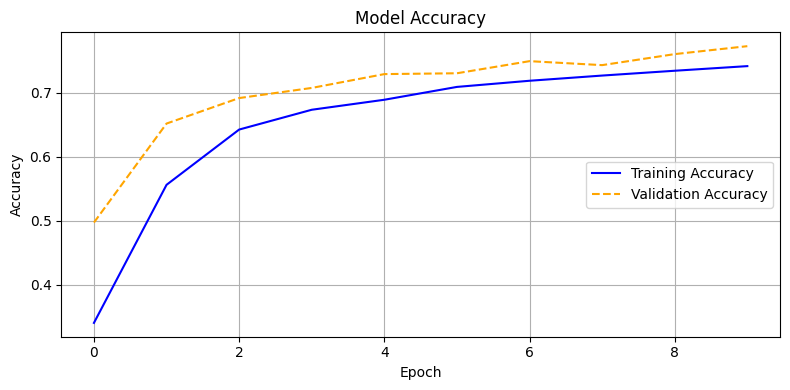

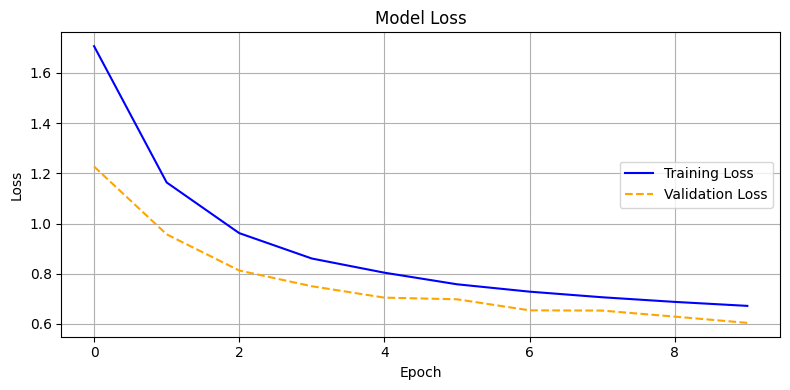

In [15]:
def plot_metrics(history, metric='accuracy'):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric], label='Training ' + metric.capitalize(), color='blue', linestyle='-')
    plt.plot(history.history['val_' + metric], label='Validation ' + metric.capitalize(), color='orange', linestyle='--')
    plt.title('Model ' + metric.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics(history, metric='accuracy')
plot_metrics(history, metric='loss')

## Model 1 Summary & Obsvervations

**Epoch 1:**

- Training Accuracy: 34.04%
- Validation Accuracy: 49.71%
- Training Loss: 1.7065
- Validation Loss: 1.2271

**Epoch 10:**

- Training Accuracy: 74.12%
- Validation Accuracy: ~77.24%
- Training Loss: ~0.6720
- Validation Loss: ~0.6042

**Observations:**

Both the training and validation accuracies show a steady increase throughout subsequent epochs. The decreasing trend in both training and validation losses indicates improved confidence in model predictions and effective error minimisation.

It's worth noting if data augmentation techniques such as rotation and shearing are applied only to the training data and not to the validation data, the diversity of the training data is increased, which can lead to better generalisation of the model and overall improved performances on the augmented validation data due to the absence of noise or distortions that is present in the training data.

This is potentially highlighted by the validation accuracy slightly outperforming the training accuracy by roughly 3% by epoch 10, suggesting good generalisation to unseen data. That being said, the augmentation techniques also led to additional required computational resources and time during training. Although it sits outside the scope of this assignment, a few considerations to mitigate the overall longer training times, include but not limited to are: reducing the augmentation intensity, increasing the batch size, simplifying the model architecture, or tuning the hyperparametres.

Further analysis across more epochs and evaluation on additional metrics could provide deeper insights into the model's behavior and performance.

---
## Building Model 2 Architecture

This stage involves constructing the model using a Keras Sequential model, comprising four distinct layers. This architecture embodies a feed-forward neural network architecture, propagating values from left to right, with each architectural layer described below.

In this model, we maintain the epoch and batch size, and substitute the previous Sigmoid activation function with ReLU.

In [16]:
# Define your neural network architecture
model_2 = Sequential([
    Flatten(input_shape=(28, 28)),  # input layer (1)
    Dense(128, activation='relu'),  # Input layer with 128 neurons
    Dense(64, activation='relu'),   # First hidden layer with 64 neurons
    Dense(32, activation='relu'),   # Second hidden layer with 32 neurons
    Dense(10, activation='softmax') # Output layer with 10 neurons (for 10 classes) using softmax activation
])

# Compile the model
model_2.compile(optimizer=SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history = model_2.fit(train_data_generator,
                    epochs=10,
                    batch_size=1000,
                    validation_data=test_data_generator)

Epoch 1/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.9127 - accuracy: 0.6523 - val_loss: 0.6695 - val_accuracy: 0.7286
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.7065 - accuracy: 0.7259 - val_loss: 0.6246 - val_accuracy: 0.7621
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.6543 - accuracy: 0.7473 - val_loss: 0.5765 - val_accuracy: 0.7742
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.6232 - accuracy: 0.7612 - val_loss: 0.5895 - val_accuracy: 0.7692
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.6052 - accuracy: 0.7702 - val_loss: 0.5949 - val_accuracy: 0.7728
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.5887 - accuracy: 0.7749 - val_loss: 0.5428 - val_accuracy: 0.7947
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.5735 - accuracy: 0.7810 - val_loss: 0.5476 -

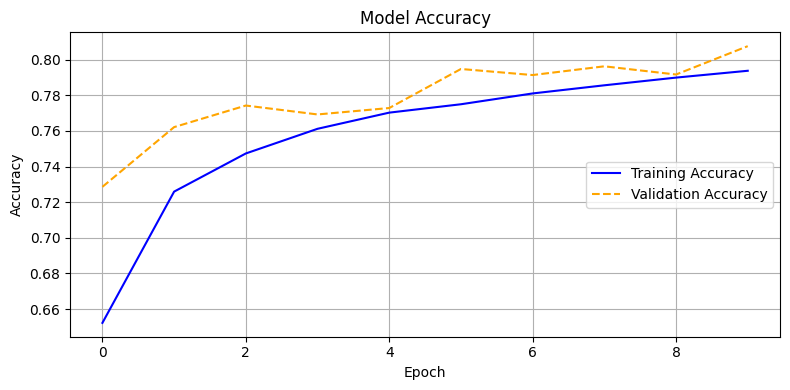

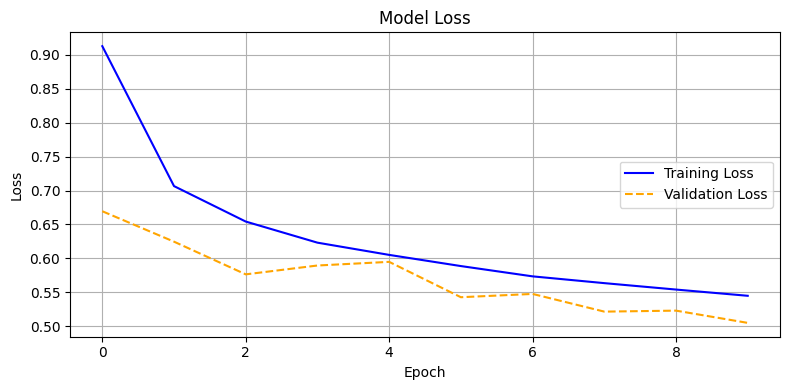

In [18]:
plot_metrics(history, metric='accuracy')
plot_metrics(history, metric='loss')

With dropout rates

In [19]:
# Neural network architecture with dropout regularization
model_2_dropout = Sequential([
    Flatten(input_shape=(28, 28)),  # input layer (1)
    Dense(128, activation='relu'),  # Input layer with 128 neurons
    Dropout(0.2),                    # Dropout layer with 20% dropout rate
    Dense(64, activation='relu'),    # First hidden layer with 64 neurons
    Dropout(0.2),
    Dense(32, activation='relu'),    # Second hidden layer with 32 neurons
    Dropout(0.2),
    Dense(10, activation='softmax')  # Output layer with 10 neurons (for 10 classes) using softmax activation
])

# Compile the model with dropout
model_2_dropout.compile(optimizer=SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
history = model_2_dropout.fit(train_data_generator,
                              epochs=10,
                              batch_size=1000,
                              validation_data=test_data_generator)

Epoch 1/10
1875/1875 [==============================] - 28s 14ms/step - loss: 1.1160 - accuracy: 0.5749 - val_loss: 0.7074 - val_accuracy: 0.7109
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.8761 - accuracy: 0.6677 - val_loss: 0.6676 - val_accuracy: 0.7340
Epoch 3/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.8210 - accuracy: 0.6884 - val_loss: 0.6383 - val_accuracy: 0.7644
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.7842 - accuracy: 0.7014 - val_loss: 0.6125 - val_accuracy: 0.7553
Epoch 5/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.7617 - accuracy: 0.7107 - val_loss: 0.6076 - val_accuracy: 0.7569
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.7409 - accuracy: 0.7212 - val_loss: 0.6099 - val_accuracy: 0.7705
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.7232 - accuracy: 0.7266 - val_loss: 0.5881 -

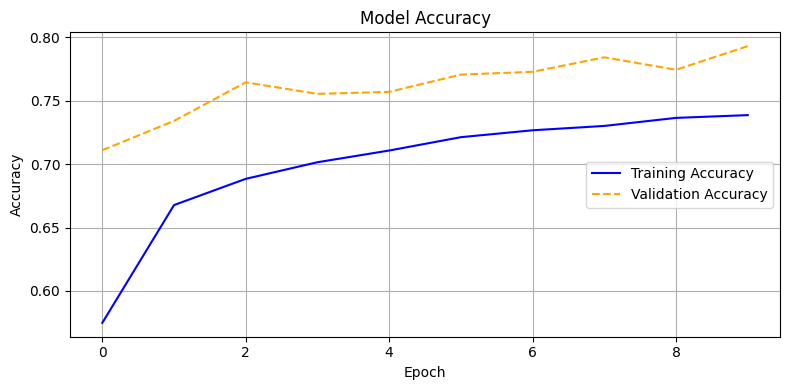

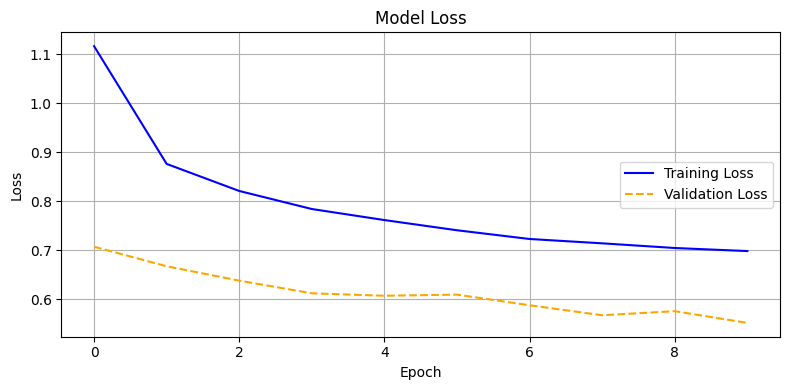

In [21]:
plot_metrics(history, metric='accuracy')
plot_metrics(history, metric='loss')